In [1]:
#NLP openai model finetuning

In [1]:
# Imports
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Paths
TRAIN = "../data/splits/train.csv"
VAL   = "../data/splits/val.csv"
TEST  = "../data/splits/test.csv"

# Load
df_tr = pd.read_csv(TRAIN)
df_va = pd.read_csv(VAL)
df_te = pd.read_csv(TEST)

# Labels
label_list = sorted(df_tr["label"].unique())
label2id = {lab:i for i,lab in enumerate(label_list)}
id2label = {i:lab for lab,i in label2id.items()}
df_tr["y"] = df_tr["label"].map(label2id).astype(int)
df_va["y"] = df_va["label"].map(label2id).astype(int)
df_te["y"] = df_te["label"].map(label2id).astype(int)

# Tokenizer (GPT-2)
tok = AutoTokenizer.from_pretrained("gpt2")
if tok.pad_token is None:
    tok.pad_token = tok.eos_token  # pad = eos

# Torch dataset
class SentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        enc = tokenizer(texts.tolist(), truncation=True, padding="max_length", max_length=max_len)
        self.input_ids = torch.tensor(enc["input_ids"])
        self.attn      = torch.tensor(enc["attention_mask"])
        self.labels    = torch.tensor(labels.tolist(), dtype=torch.long)
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {"input_ids": self.input_ids[i],
                "attention_mask": self.attn[i],
                "labels": self.labels[i]}

train_ds = SentDataset(df_tr["sentence"], df_tr["y"], tok)
val_ds   = SentDataset(df_va["sentence"], df_va["y"], tok)
test_ds  = SentDataset(df_te["sentence"], df_te["y"], tok)

len(train_ds), label_list


c:\Users\Burak\anaconda3\envs\gpt2env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(4089, ['negative', 'neutral', 'positive'])

In [2]:



num_labels = len(label_list)

# Model
model = AutoModelForSequenceClassification.from_pretrained(
    "gpt2",
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label
)
model.config.pad_token_id = tok.pad_token_id

# Freeze base (train head only = transfer learning)
for name, p in model.named_parameters():
    if not name.startswith("score"):
        p.requires_grad = False

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

# Train args (fast)
args = TrainingArguments(
    output_dir="../models/gpt2-head-only",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    learning_rate=5e-3,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_steps=50,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tok,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Burak\anaconda3\envs\gpt2env\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 0/1024 [00:00<?, ?it/s]c:\Users\Burak\anaconda3\envs\gpt2env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  5%|▍         | 50/1024 [05:16<1:37:35,  6.01s/it]

{'loss': 1.379, 'grad_norm': 12.347182273864746, 'learning_rate': 0.004755859375, 'epoch': 0.1}


 10%|▉         | 100/1024 [10:42<1:20:49,  5.25s/it]

{'loss': 1.0719, 'grad_norm': 56.66871643066406, 'learning_rate': 0.00451171875, 'epoch': 0.2}


 15%|█▍        | 150/1024 [15:18<1:32:07,  6.32s/it]

{'loss': 0.9374, 'grad_norm': 119.34615325927734, 'learning_rate': 0.004267578125, 'epoch': 0.29}


 20%|█▉        | 200/1024 [19:58<1:09:16,  5.04s/it]

{'loss': 1.0245, 'grad_norm': 64.17362976074219, 'learning_rate': 0.0040234375, 'epoch': 0.39}


 24%|██▍       | 250/1024 [24:16<1:06:42,  5.17s/it]

{'loss': 0.9295, 'grad_norm': 54.017086029052734, 'learning_rate': 0.003779296875, 'epoch': 0.49}


 29%|██▉       | 300/1024 [28:40<1:03:31,  5.26s/it]

{'loss': 0.8963, 'grad_norm': 32.667755126953125, 'learning_rate': 0.00353515625, 'epoch': 0.59}


 34%|███▍      | 350/1024 [33:03<58:08,  5.18s/it]  

{'loss': 0.8875, 'grad_norm': 37.60175704956055, 'learning_rate': 0.003291015625, 'epoch': 0.68}


 39%|███▉      | 400/1024 [37:22<53:26,  5.14s/it]

{'loss': 1.0288, 'grad_norm': 16.346851348876953, 'learning_rate': 0.003046875, 'epoch': 0.78}


 44%|████▍     | 450/1024 [41:43<49:50,  5.21s/it]

{'loss': 0.8958, 'grad_norm': 129.2200927734375, 'learning_rate': 0.002802734375, 'epoch': 0.88}


 49%|████▉     | 500/1024 [46:05<45:15,  5.18s/it]

{'loss': 0.7843, 'grad_norm': 57.160160064697266, 'learning_rate': 0.00255859375, 'epoch': 0.98}


                                                  
 50%|█████     | 512/1024 [53:58<32:59,  3.87s/it]c:\Users\Burak\anaconda3\envs\gpt2env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.7341084480285645, 'eval_accuracy': 0.680365296803653, 'eval_f1_weighted': 0.6485922917145487, 'eval_runtime': 415.3505, 'eval_samples_per_second': 2.109, 'eval_steps_per_second': 0.132, 'epoch': 1.0}


 54%|█████▎    | 550/1024 [57:19<41:49,  5.29s/it]    

{'loss': 0.7842, 'grad_norm': 68.34996795654297, 'learning_rate': 0.002314453125, 'epoch': 1.07}


 59%|█████▊    | 600/1024 [1:01:41<36:27,  5.16s/it]

{'loss': 0.8317, 'grad_norm': 61.33763885498047, 'learning_rate': 0.0020703125, 'epoch': 1.17}


 63%|██████▎   | 650/1024 [1:06:00<31:44,  5.09s/it]

{'loss': 0.7532, 'grad_norm': 22.617393493652344, 'learning_rate': 0.001826171875, 'epoch': 1.27}


 68%|██████▊   | 700/1024 [1:10:24<27:29,  5.09s/it]

{'loss': 0.7469, 'grad_norm': 17.66736602783203, 'learning_rate': 0.00158203125, 'epoch': 1.37}


 73%|███████▎  | 750/1024 [1:14:46<23:50,  5.22s/it]

{'loss': 0.8071, 'grad_norm': 104.28998565673828, 'learning_rate': 0.001337890625, 'epoch': 1.46}


 78%|███████▊  | 800/1024 [1:19:06<19:26,  5.21s/it]

{'loss': 0.6954, 'grad_norm': 60.91526794433594, 'learning_rate': 0.00109375, 'epoch': 1.56}


 83%|████████▎ | 850/1024 [1:23:33<20:21,  7.02s/it]

{'loss': 0.6309, 'grad_norm': 16.644092559814453, 'learning_rate': 0.000849609375, 'epoch': 1.66}


 88%|████████▊ | 900/1024 [1:28:45<12:03,  5.83s/it]

{'loss': 0.7115, 'grad_norm': 45.38142013549805, 'learning_rate': 0.00060546875, 'epoch': 1.76}


 93%|█████████▎| 950/1024 [1:33:36<07:11,  5.84s/it]

{'loss': 0.7092, 'grad_norm': 18.27825164794922, 'learning_rate': 0.000361328125, 'epoch': 1.86}


 98%|█████████▊| 1000/1024 [1:38:29<02:23,  5.97s/it]

{'loss': 0.6755, 'grad_norm': 62.022701263427734, 'learning_rate': 0.0001171875, 'epoch': 1.95}


                                                     
100%|██████████| 1024/1024 [1:47:42<00:00,  6.31s/it]

{'eval_loss': 0.6910309791564941, 'eval_accuracy': 0.6815068493150684, 'eval_f1_weighted': 0.6654343348517606, 'eval_runtime': 419.4759, 'eval_samples_per_second': 2.088, 'eval_steps_per_second': 0.131, 'epoch': 2.0}
{'train_runtime': 6462.9053, 'train_samples_per_second': 1.265, 'train_steps_per_second': 0.158, 'train_loss': 0.8564490899443626, 'epoch': 2.0}


TrainOutput(global_step=1024, training_loss=0.8564490899443626, metrics={'train_runtime': 6462.9053, 'train_samples_per_second': 1.265, 'train_steps_per_second': 0.158, 'total_flos': 534226030166016.0, 'train_loss': 0.8564490899443626, 'epoch': 2.0})

c:\Users\Burak\anaconda3\envs\gpt2env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 55/55 [06:46<00:00,  7.38s/it]


              precision    recall  f1-score   support

    negative       0.47      0.29      0.36       129
     neutral       0.73      0.87      0.79       470
    positive       0.66      0.56      0.61       278

    accuracy                           0.69       877
   macro avg       0.62      0.58      0.59       877
weighted avg       0.67      0.69      0.67       877



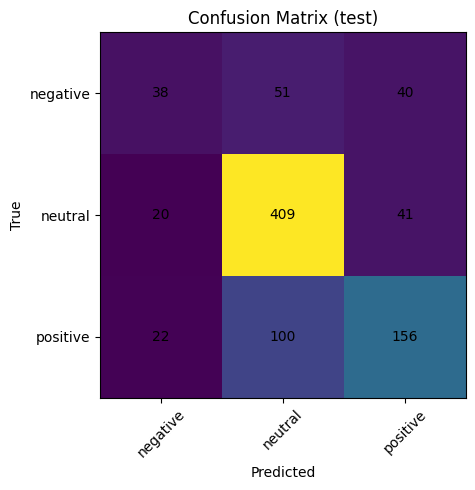

In [3]:



out = trainer.predict(test_ds)
y_true = out.label_ids
y_pred = out.predictions.argmax(axis=-1)

print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(num_labels)]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (test)")
plt.xticks(range(num_labels), [id2label[i] for i in range(num_labels)], rotation=45)
plt.yticks(range(num_labels), [id2label[i] for i in range(num_labels)])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()


In [4]:

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Totalt antal parametrar: {total_params:,}")
print(f"Tränade parametrar: {trainable_params:,}")
print(f"Frysta parametrar: {frozen_params:,}")
print(f"Andel tränade: {trainable_params/total_params:.6f} ({100*trainable_params/total_params:.4f}%)")


Totalt antal parametrar: 124,442,112
Tränade parametrar: 2,304
Frysta parametrar: 124,439,808
Andel tränade: 0.000019 (0.0019%)
